

## **Advances in Data Mining**

Stephan van der Putten | (s1528459) | stvdputtenjur@gmail.com  
Theo Baart | s2370328 | s2370328@student.leidenuniv.nl

### **Assignment 2**
This assignment is concerned with finding the set of similar users in the provided datasource. To be more explicit, in finding all pairs of users who have a Jaccard similarity of more than 0.5. Additionally, this assignment considers comparing the "naïve implementation" with the "LSH implementation". The "naïve implementation" can be found in the file `time_estimate.ipynb` and the "LSH implementation" in the file `lsh.ipynb`.

Note all implementations are based on the assignment guidelines and helper files given as well as the documentation of the used functions. Additionally, the following sources have been referenced and used as inspiration:
  1. CMSC643: Machine Learning and Data Mining: <http://www.hcbravo.org/dscert-mldm/projects/project_1/>
  2. Shared_Minhash_and_LSH_from_binned_date: <https://colab.research.google.com/drive/1HetBrWFRYqwUxn0v7wIwS7COBaNmusfD#scrollTo=hzPw8EMoW4i4&forceEdit=true&sandboxMode=true>


#### **LSH Implementation**
This notebook implements LSH in order to find all pairs of users with a Jaccard similarity of more than 0.5. As noted in the assignment instructions the data file is loaded from `user_movie.npy` and the list of user pairs are printed in the file `ans.txt`. Additionally, this implementation supports the setting of a random seed to determine the permutations to be used in LSH. The algorithm will continually save its output so as to aid in the evaluation criteria which only looks at the first 15 minutes of the LSH execution.
___

### **Helper Functions**
This section contains functions which aid and simplify the code for our LSH implementation
___

The following snippet handles all imports.

In [2]:
import time
import sys
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, find
from collections import defaultdict
import scipy.optimize as opt
import math
import itertools as it
from scipy import sparse

The `compute_num_bands` function computes the theoretical optimal number of bands to use given a threshold and signature size. This is a slightly modified version of the `choose_nbands` function given in [1].

In order to do this the function uses the following parameters:
  * `t` - the desired threshold value
  * `s` - the size of the signature
  
Additionally, it returns the following values:
  * `b` - the suggested number of bands to use
  * `final_t` - the computed threshold for this number of bands

In [3]:
def compute_num_bands(t, s):
    def error_fun(x):
        cur_t = (1/x[0])**(x[0]/s)
        return (t-cur_t)**2

    opt_res = opt.minimize(error_fun, x0=(10), method='Nelder-Mead')
    b = int(math.ceil(opt_res['x'][0]))
    r = round(s / b)
    final_t = (1/b)**(1/r)
    return b, final_t

The `generate_signature_hash_function` function generates a random hash function which returns a large numeric value to be used for hashing signatures into buckets. This is a slightly modified version of the `make_random_hash_fn` function given in [1].

In order to do this the function uses the following parameters:
  * `p` - largest value which can be randomly selected [default: 2^31 - 1]
  * `k` - the number of buckets to use [default: 12884901885]
  
Additionally, it returns the following value:
  * `lambda` - a lambda function representing the random hash function

In [4]:
def generate_signature_hash_function(p=2**31-1, k=12884901885):#4294967295):
    a = np.random.randint(1,p-1)
    b = np.random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % k

The `write_pair_to_file` function writes the given pair of users to the specified file.

In order to do this the function uses the following parameters:
  * `pair` - the pair of users to write to the file
  * `path` - the filepath of the file to write to  [`ans.txt`]

In [5]:
def write_pair_to_file(pair,path='ans.txt'):
    file = open(path, "a+")
    line = str(pair[0]) + ', ' + str(pair[1]) + '\r\n'
    file.write(line)
    file.close()

### **LSH Class**

This section contains the class and its functions which execute the various steps of the LSH algorithm. Due to the limitations of `.ipynb` files the various functions will be described first and then the implementation will be shown.

___


The `__init__` function initializes the class and sets the random seed to a specific value.

In order to do this the function uses the following parameters:
  * `dataset` - the raw user-movie data [default: None]
  * `sparse_matrix` - the sparse matrix to use [default: None]
  * `signature_length` - the number of signatures/permutations to use [default: 50]
  * `permutations` - the array of permutations to use [default: None]
  * `signature_matrix` - the signature matrix to use [default: None]
  * `buckets` - the LSH buckets to use [default: None]
  * `random_seed` - the seed to use for generating random numbrs [default: 10102020]
___
The `load` function loads data and stores it in `dataset`.

In order to do this the function uses the following parameters:
  * `path` - the location of the data to load
___
The `create_sparse_matrix` function transforms the dataset into a sparse matrix such that a 1 signifies that a user [column] has watched that specific movie [row]
___
The `generate_permutations` function generates an array of `signature_lenght` random permutations of the rows in the `sparse_matrix`.
___
The `generate_signature_matrix` function generates the `signature_matrix` by minhashing the permutations on the `sparse_matrix`. This function is a modified implementation of the `minhash_signature` function in [2].
___
the `split_to_buckets` function takes the signature matrix, applies banding and then places the users [columns] into buckets. This function is based on the implementations of `do_lsh` in [1] and `lsh_r_bucket_to_id` in [2].

In order to do this the function uses the following parameters:
  * `b` - the number of bands to use
  * `r` - the number of rows to use
___
The `compute_similarity` function computes the estimated jaccard similarity of two arrays.

In order to do this the function uses the following parameters:
  * `first` - the first array to compare
  * `second` - the second array to compare
  
Additionally, it returns the following value:
  * `similarity` - the jaccard similarity of the two arrays
___
the `get_pairs_from_buckets` function takes LSH buckets and extracts the user pairs with an estimated similarity >= the threshold (default 0.5). Additionally, these pairs are written to file. 

In [6]:
class LSH():
    
    def __init__(self, dataset=None, sparse_matrix=None, 
                 signature_length=100, permutations=None, signature_matrix=None, buckets=None, random_seed=10102020, threshold=0.5):
        self.dataset = dataset
        self.signature_length = signature_length
        self.sparse_matrix = sparse_matrix
        self.permutations = permutations
        self.signature_matrix = signature_matrix
        self.buckets = buckets
        self.threshold = threshold
        np.random.seed(seed=random_seed)
    
    def load(self, path):
        self.dataset = np.load(path)

    def create_sparse_matrix(self):
        c = self.dataset[:,0]
        r = self.dataset[:,1]
        d = np.ones(len(c))
        max_c = len(np.unique(c))
        max_r = len(np.unique(r))
        self.sparse_matrix = csr_matrix((d,(r,c)), shape=(max_r, max_c), dtype=np.uint16)
        
    def generate_permutations(self):
        self.permutations = np.array([np.random.permutation(self.sparse_matrix.shape[0]) for i in range(self.signature_length)], dtype=np.uint16)
        
    def generate_signature_matrix(self):
        sigm = np.full((self.signature_length, self.sparse_matrix.shape[1]), 17700, dtype=np.uint16)
        number_of_rows = self.sparse_matrix.shape[0]
#         t1 = time.time() 
        for row in range(number_of_rows):
#             if row % 5000==0:
#                 print(str(round(100*row/number_of_rows,2))+' percent complete in '+str(round(time.time()-t1,2))+ ' seconds')
            ones = find(self.sparse_matrix[row, :])[1]
            perm = self.permutations[:,row]
            B = sigm.copy()
            B[:,ones] = 1
            B[:,ones] = np.multiply(B[:,ones], perm[:, np.newaxis])
            sigm = np.minimum(sigm, B)
        self.signature_matrix = sigm
    
    def split_to_buckets(self,b,r):
        user_ids = np.array(list(range(self.signature_matrix.shape[1])))
        number_of_users = self.signature_matrix.shape[1]
        buckets = defaultdict(list)
        hf = generate_signature_hash_function()
#         t1 = time.time()    
        for i in range(number_of_users):
#             if i % 10000==0:
#                 print(str(round(100*i/number_of_users,2))+' percent complete in '+str(round(time.time()-t1,2))+ ' seconds')
            row = self.signature_matrix[:,i] 
            for j in range(b):
                r_signature = str(row[j*r:(j+1)*r])
                r_hash = hash(r_signature)
                r_hash = hf(r_hash)
                buckets[r_hash].append(user_ids[i])
        buckets_set = {k: set(v) for k,v in buckets.items()}
        self.buckets = buckets_set
    
    def compute_similarity(self,f,s):
        b = 0
        l = 0
        r = 0
        first = self.signature_matrix[:,f]
        second = self.signature_matrix[:,s]
        for i in range(self.signature_length):
            if first[i] == second[i]:
                b += 1
            elif first[i] < second[i]:
                r += 1
            else:
                l += 1
        similarity = b / (b + l + r)
        return similarity
    
    def get_pairs_from_buckets(self):
        all_pairs = set ()
        full_buckets = {k: v for k, v in self.buckets.items() if len(v) >= 2}
        number_of_buckets = len(full_buckets)
        counter = 0
#         t1 = time.time()  
        for v in full_buckets.values():
#             if counter % 10000==0:
#                 print(str(round(100*counter/number_of_buckets,2))+' percent complete in '+str(round(time.time()-t1,2))+ ' seconds')
#             counter += 1
            bucket_pairs = set(it.combinations(v,2))
            for pair in bucket_pairs:
                if pair not in all_pairs and self.compute_similarity(pair[0],pair[1]) >= self.threshold:
                    # only write unique pairs with sim > threshold
                    write_pair_to_file(pair)
                    counter += 1
            all_pairs.update(bucket_pairs)
        print('lenght of all_pairs = '+str(counter))

### **Program Execution**
This section is concerned with parsing the input arguments and determining the execution flow of the program.

___
The `main` function handles the command line arguments and is responsible for the main flow of the program.

In order to do this the function uses the following parameter:
  * `path` - the location for the `user_movies.npy` file [default = 'datasets/user_movie.npy']
  * `threshold` - the targeted threshold value

In [6]:
def main(path = 'datasets/user_movie.npy', threshold = 0.5):
    lsh = LSH()
    lsh.load(path)
    
    lsh.create_sparse_matrix()
    lsh.generate_permutations()
    lsh.generate_signature_matrix()

    # SEE DISCUSSION 
#     b, _t = compute_num_bands(threshold, lsh.signature_length) 
#     r = round(lsh.signature_length / b)
    r = 10
    b = round(lsh.signature_length / r)
    lsh.split_to_buckets(b,r)
    lsh.get_pairs_from_buckets()

The following snippet passes the start of the program and the command line arguments to the `main` function.

The following command line argument is expected:
  * `path` - the location of the `user_movies.npy` file


In [7]:
if __name__ == "__main__":
    filepath = sys.argv[1]
    start_time = time.time()
    main(path=filepath)

### **Discussion**

An important point of discussion with regards to our implementation of LSH concerns the number of bands to use and the size of each band. In the assignment notes it is required that the similarity threshold is 0.5. Based on this requirement the `compute_num_bands` function the number of bands (and their size) can be computed to be as close to the threshold as possible. However, when running the algorithm this results in a significant amount of candidate pairs (100's of thousands). Many of these pairs also have an estimated jaccard similarity (based on their signatures) of less than 0.5. In other words, there are far too many false positives. Thus, we played with various settings for the number of bands and rows as well as experimenting with a signature size of 50 and 100. See *Figure 1* in the cell below for a visual representation of our experimental results. Note that the red dotted line in *Figure 1* represents the actual (given) number of pairs in the dataset. Eventually, and on the advice of the teaching assistants, we settled with a band size of 10 rows. This brings the number of candidate pairs to a significantly smaller scope and much closer to the given amount of similar pairs (namely 1219). Additionally, we opted for a signature length of 50. Looking at the results this combination of band size and signature length had the quickest runtime as well as coming closest to correctly estimating the number of pairs there are.

However, using the formula for estimated similarity threshold we do observe that a band size of 10 rows and our signature size of 50 results in an similarity threshold of approximately 0.85 during the execution of the `split_to_buckets` function. Obviously, during the verification of the candidate pairs only those pairs will be selected which actually have a similarity threshold of at least 0.5 (per the assignment requirements). However, the higher threshold during the `split_to_buckets` function means that the chance is much higher that there will be false negatives: i.e. pairs with a similarity of at least 0.5 which are not part of the candidate pairs. Increasing the signature size (and hence the number of bands) will decrease the estimated similarity threshold during the execution of `split_to_buckets`, but the problem of false negatives will still remain. Nevertheless, we have kept the suggested band size of 10 rows as the possibility of a false negative is less detrimental to finding as many pairs as possible in 15 minutes as a guarantee of a large set of false positives. Furthermore, it gives us more time to compare and verify candidate pairs with regards to their estimated jaccard similarity. 



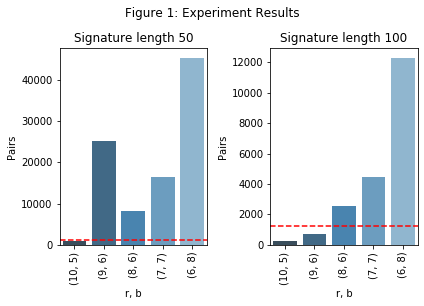

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
plot50 = pd.DataFrame({
    'r, b' : [(10, 5), (9, 6), (8, 6), (7, 7), (6, 8)],
    'Pairs' : [900, 25144, 8139, 16396, 45367],
})
plot100 = pd.DataFrame({
    'r, b' : [(10, 5), (9, 6), (8, 6), (7, 7), (6, 8)],
    'Pairs' : [276, 694, 2544, 4456, 12296],
})
plt.suptitle('Figure 1: Experiment Results', y=1.05)

plt.subplot(121)
plt.xticks(rotation='vertical')
ax = sns.barplot(x="r, b", y="Pairs", data=plot50, palette="Blues_d")
ax.set_title('Signature length 50')
plt.axhline(1219,color='red',ls='--')

plt.subplot(122)
plt.xticks(rotation='vertical')
ax = sns.barplot(x="r, b", y="Pairs", data=plot100, palette="Blues_d")
ax.set_title('Signature length 100')
plt.axhline(1219,color='red',ls='--')

plt.tight_layout()
plt.show()